# Neural Network Functional Approximation of Stock Market Volatility

## Introduction
---
Given the architecture of Neural Networks, they are typically thought of as a computerised simulation of the human brain. However, an alternative way of thinking about Neural Networks, which might be more apt, is that neural networks are function approximators. In this simple project, I attempt to use a regular Feed Forward Neural Network (the simplest kind, truly), as a function approximator for the volatility of a stock market index. 

The following data is used for the analysis, to predict the volatility of the S&P 500 ETF:
* USA Consumer Price Index (CPI)
* Daily Effective Federal Reserve Funds Rate (DFF)
* USA Gross Domestic Product (GDP)
* USA Unemployment Rate (UNRATE)
* Volatility of the previous 5 days

## Preparing the Data
---

In [2]:
import pandas as pd
from datetime import datetime
import yfinance as yf
from scipy import stats, special
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

plt.style.use('dark_background')

In [3]:
# CPI dataset (monthly data)
with open("CPI.csv", "r") as file:
    cpi_data = pd.read_csv(file)
    cpi_data['DATE'] = cpi_data['DATE'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").date())
    cpi_data.set_index('DATE', inplace=True)

In [4]:
# Daily effective fed funds rate dataset (daily data)
with open("DFF.csv", "r") as file:
    dff_data = pd.read_csv(file)
    dff_data['DATE'] = dff_data['DATE'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
    dff_data.set_index('DATE', inplace=True)

In [5]:
# gdp dataset (quarterly data)
with open("GDP.csv", "r") as file:
    gdp_data = pd.read_csv(file)
    gdp_data['DATE'] = gdp_data['DATE'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
    gdp_data.set_index('DATE', inplace=True)

In [6]:
# unemployment rate data (monthly data)
with open("UNRATE.csv", "r") as file:
    unrate_data = pd.read_csv(file)
    unrate_data['DATE'] = unrate_data['DATE'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
    unrate_data.set_index('DATE', inplace=True)


In [7]:
dfs = [dff_data, unrate_data, cpi_data, gdp_data]

last_data = [df.index[-1] for df in dfs]
last_data = min(last_data)

dff_data = dff_data.loc[:last_data]
unrate_data = unrate_data.loc[:last_data]
cpi_data = cpi_data.loc[:last_data]
gdp_data = gdp_data.loc[:last_data]

In [8]:
dfs = [dff_data, unrate_data, cpi_data, gdp_data]

merged_data = pd.concat(dfs, axis=1, join="outer")

# forward fill the missing data because this is the data the market gets to work with until the next data release
merged_data.fillna(method = "ffill", inplace = True)

In [9]:
spy = yf.Ticker("SPY")
spy_data = spy.history(period = "max")

spy_data.index = spy_data.index.strftime("%Y-%m-%d")
spy_data.index = spy_data.index.map(str)
spy_data.index = spy_data.index.map(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

spy_data.drop(["Volume", "Dividends", "Stock Splits", "Capital Gains"], axis = 1, inplace = True)

spy_data["Volatility"] = (spy_data["High"] - spy_data["Low"]) / (spy_data["Open"]) * 100 

For the scope of this project, volatility is defined to be $$ \frac{high - low}{open} $$ which is a more intuitive approach to volatility rather that computing standard deviations. The primary bonus of defining volatilty as such is that one could use the model's predictions before the market opens to easily estimate the day's likely volatility. 

## Target Variable Data Transformation
---
Due to the definition of volatility for this project as stated above, the data for volatility is heavily skewed and unevenly distributed. Thus, a Box-Cox transformation is used to normalise the data for prediction in hopes that it results in the model having better predictive ability. An inverse Box-Cox transformation with the same ${\lambda}$ value will then be used to get revert the predictions to the definition.

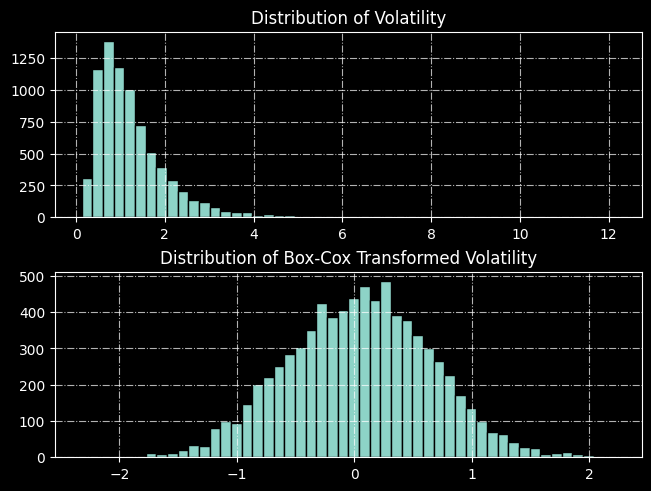

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout = True)

ax1.grid(linestyle='-.', alpha=0.7)
ax2.grid(linestyle='-.', alpha=0.7)

ax1.title.set_text("Distribution of Volatility")
ax2.title.set_text("Distribution of Box-Cox Transformed Volatility")

spy_data["Volatility"] = (spy_data["High"] - spy_data["Low"]) / spy_data["Open"] * 100 
ax1.hist(spy_data["Volatility"], bins = 50, edgecolor='black', linewidth=1)

spy_data["Volatility"], lmbda = stats.boxcox(spy_data["Volatility"].values)
ax2.hist(spy_data["Volatility"], bins = 50, edgecolor='black', linewidth=1)

plt.show();

In [11]:
for i in range (1, 6):
    spy_data[f"t-{i}"] = spy_data["Volatility"].shift(i)

In [12]:
new_merge = pd.merge(merged_data, spy_data, left_index=True, right_index=True)
new_merge.drop(["Open", "High", "Low", "Close"], axis = 1, inplace = True)

new_merge.dropna(inplace = True)

print(new_merge.head())

             DFF  UNRATE       CPI       GDP  Volatility       t-1       t-2  \
1993-02-05  2.87     7.1  0.350631  6729.459   -0.272134  0.324049  0.053964   
1993-02-08  2.94     7.1  0.350631  6729.459   -0.746149 -0.272134  0.324049   
1993-02-09  2.90     7.1  0.350631  6729.459   -0.600279 -0.746149 -0.272134   
1993-02-10  2.88     7.1  0.350631  6729.459   -0.738678 -0.600279 -0.746149   
1993-02-11  2.97     7.1  0.350631  6729.459   -0.267847 -0.738678 -0.600279   

                 t-3       t-4       t-5  
1993-02-05 -0.586181 -0.456547 -0.722074  
1993-02-08  0.053964 -0.586181 -0.456547  
1993-02-09  0.324049  0.053964 -0.586181  
1993-02-10 -0.272134  0.324049  0.053964  
1993-02-11 -0.746149 -0.272134  0.324049  


## The Model
---

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
torch.manual_seed(123) # manual seed for repeatability and ease of comparison

In [14]:
class Model(nn.Module):
    # 9 inputs -> t-1 to t-5, dff, unrate, cpi, gdp
    # 1 output -> volatility

    def __init__(self, in_features = 9, h1 = 12, h2 = 6, h3 = 3, out_features = 1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)

        return x

In [15]:
model = Model()

x = new_merge.drop("Volatility", axis = 1)
y = new_merge["Volatility"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

x_train = torch.FloatTensor(x_train.values)
x_test = torch.FloatTensor(x_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 0.001)

In [16]:
epochs = 100
losses = []

for i in range(epochs):
    y_pred = model.forward(x_train)

    loss = criterion(y_pred, y_train.view(-1, 1))

    losses.append(loss.detach().numpy())

    if i%10 == 0:
        print(f"Epoch {i} and loss {loss}")

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch 0 and loss 3.094036340713501
Epoch 10 and loss 0.774933934211731
Epoch 20 and loss 0.39172208309173584
Epoch 30 and loss 0.41097286343574524
Epoch 40 and loss 0.3916762173175812
Epoch 50 and loss 0.3943408131599426
Epoch 60 and loss 0.3916168212890625
Epoch 70 and loss 0.39167100191116333
Epoch 80 and loss 0.39128684997558594
Epoch 90 and loss 0.3912266492843628


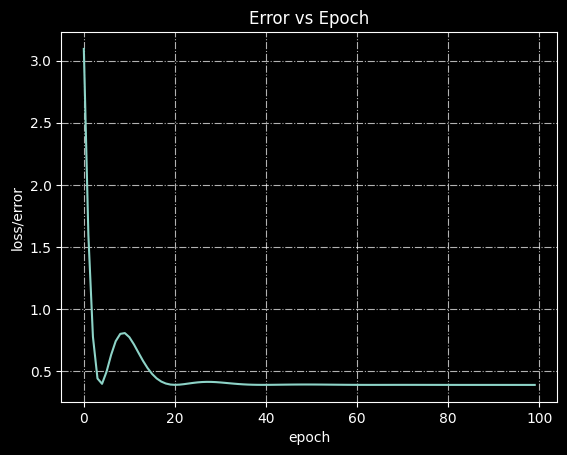

In [25]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel("epoch")
plt.title("Error vs Epoch")
plt.grid(linestyle='-.', alpha=0.7)
plt.show();

In [23]:
with torch.no_grad():
    y_eval = model.forward(x_test)
    loss = criterion(y_eval, y_test.view(-1, 1))
    print(f"Mean Squared Error of evaluation of testing data: {loss}")

Mean Sqaured Error of evaluation of testing data: 0.3854003846645355


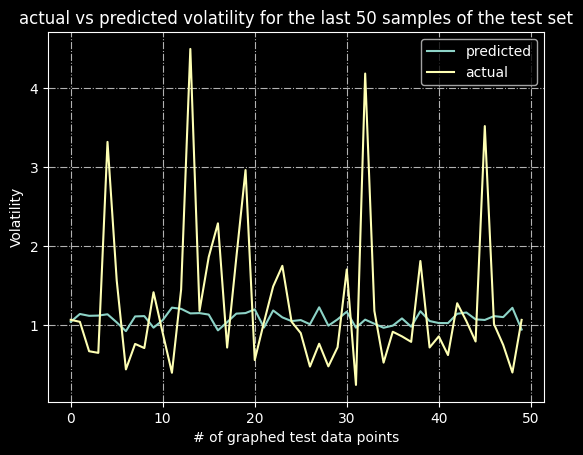

In [28]:
plt.plot(special.inv_boxcox(y_eval[:50], lmbda), label = "predicted")
plt.plot(special.inv_boxcox(y_test[:50], lmbda), label = "actual")

plt.legend()
plt.ylabel("Volatility")
plt.xlabel("# of graphed test data points")
plt.title('actual vs predicted volatility for the last 50 samples of the test set')
plt.grid(linestyle='-.', alpha=0.7)
plt.show();

## Model Commentry
---
The movement of the model's predictions are somewhat able to match that of the market's, i.e. when there is an increase in volatility, the model predicts an increase as well. However, the model fails dramatically to produce predictions that match the magnitude of the actual volatility of the market and it's predictions appear more akin to a moving average that the actual market volatility swings about. Hence, one can conclude that this model is likely not of much use in a real-world setting.

## Model Limitations
---
The factors that affect stock market volatility are numerous and complicated in nature, hence it is a tough ask to expect a regular feed forward neural network to give a good functional approximation of the stock market's volatility. Furthermore, this task is made tougher by how volatility was defined in this project scope -- ${volatility = (high - low) / open * 100}$, so that one could use the model prior to market opening to predict the day's volatility. Such a definition for volatility results in wide-ranging and skewed data. Future research areas for such a project would include: (1) Conversion of the model to one that is better suited for time series predictions e.g. Long/Short Term Memory or Radial Basis Network (2) using a different definition of volatility e.g. rolling standard deviation (3) addition of more predictor variables (stay tuned :).